With the help of Python, Pandas, and Scikit-Learn, we will forecast stock prices in this project. We'll download stock prices, build a machine learning model, and build a back-testing engine along the way.

Making lucrative stock trades with little risk is the goal. Therefore, we want to be reasonably assured that the price will increase when we buy a stock. When the market opens, we'll buy the stock, and when it closes, we'll sell it.

First, lets import the required libraries and read the .csv files.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date

sys=pd.read_csv('SYS1.csv')
usd=pd.read_csv('USD1.csv')
sys.set_index('Date', inplace=True)

df= pd.merge(sys, usd, on='Date', how='left', suffixes=('_S','_D'))  
# Reverse rows using iloc() Function
df = df.iloc[::-1]
df.ffill(axis = 0)
df

,Date,Price_S,Open_S,High_S,Low_S,Vol._S,Change %_S,Price_D,Open_D,High_D,Low_D,Vol._D,Change %_D
1004,01/01/2019,89.83,90.80,90.91,89.30,14.64K,-1.07%,139.800,139.800,139.800,139.800,0.11K,0.00%
1003,01/03/2019,87.93,86.94,87.93,86.94,2.66K,-2.12%,139.850,139.850,140.040,138.350,1.50K,0.00%
1002,01/04/2019,87.93,90.08,90.08,90.08,0.12K,0.00%,139.850,139.850,140.000,135.370,1.92K,0.00%
1001,01/07/2019,88.43,88.43,88.60,88.40,123.18K,0.57%,139.850,139.850,140.000,138.400,0.05K,0.00%
1000,01/08/2019,88.87,88.43,90.91,88.41,38.24K,0.50%,139.875,139.825,139.975,138.365,0.16K,0.02%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,01/13/2023,494.63,496.00,499.95,486.00,332.39K,-0.68%,228.600,228.665,228.925,228.000,0.48K,0.12%
3,01/16/2023,489.50,497.98,497.99,484.50,250.61K,-1.04%,228.750,228.800,228.925,228.425,0.52K,0.07%
2,01/17/2023,463.48,490.89,491.00,451.62,1.04M,-5.32%,229.000,228.875,229.510,228.525,0.55K,0.11%
1,01/18/2023,479.99,458.20,484.00,458.20,499.57K,3.56%,229.250,229.500,229.635,228.750,0.53K,0.11%


We will remove the columns that are not important and make a new DataFrame to work with.

In [ ]:
df1= df[['Date','Price_S','Open_S','High_S','Low_S','Vol._S', 'Price_D']].copy()
df1

,Date,Price_S,Open_S,High_S,Low_S,Vol._S,Price_D
1004,01/01/2019,89.83,90.80,90.91,89.30,14.64K,139.800
1003,01/03/2019,87.93,86.94,87.93,86.94,2.66K,139.850
1002,01/04/2019,87.93,90.08,90.08,90.08,0.12K,139.850
1001,01/07/2019,88.43,88.43,88.60,88.40,123.18K,139.850
1000,01/08/2019,88.87,88.43,90.91,88.41,38.24K,139.875
...,...,...,...,...,...,...,...
4,01/13/2023,494.63,496.00,499.95,486.00,332.39K,228.600
3,01/16/2023,489.50,497.98,497.99,484.50,250.61K,228.750
2,01/17/2023,463.48,490.89,491.00,451.62,1.04M,229.000
1,01/18/2023,479.99,458.20,484.00,458.20,499.57K,229.250


Convert the Volume column to float to make the dataset easier to interpret.

In [ ]:
#convert 'K','M' and 'B' to absolute values 
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

df1['Vol._S'] = df1['Vol._S'].apply(value_to_float)

df1

,Date,Price_S,Open_S,High_S,Low_S,Vol._S,Price_D
1004,01/01/2019,89.83,90.80,90.91,89.30,14640.0,139.800
1003,01/03/2019,87.93,86.94,87.93,86.94,2660.0,139.850
1002,01/04/2019,87.93,90.08,90.08,90.08,120.0,139.850
1001,01/07/2019,88.43,88.43,88.60,88.40,123180.0,139.850
1000,01/08/2019,88.87,88.43,90.91,88.41,38240.0,139.875
...,...,...,...,...,...,...,...
4,01/13/2023,494.63,496.00,499.95,486.00,332390.0,228.600
3,01/16/2023,489.50,497.98,497.99,484.50,250610.0,228.750
2,01/17/2023,463.48,490.89,491.00,451.62,1040000.0,229.000
1,01/18/2023,479.99,458.20,484.00,458.20,499570.0,229.250


In [ ]:
df1.set_index('Date', inplace=True)
print(df1)

            Price_S  Open_S  High_S   Low_S     Vol._S  Price_D
Date                                                           
01/01/2019    89.83   90.80   90.91   89.30    14640.0  139.800
01/03/2019    87.93   86.94   87.93   86.94     2660.0  139.850
01/04/2019    87.93   90.08   90.08   90.08      120.0  139.850
01/07/2019    88.43   88.43   88.60   88.40   123180.0  139.850
01/08/2019    88.87   88.43   90.91   88.41    38240.0  139.875
...             ...     ...     ...     ...        ...      ...
01/13/2023   494.63  496.00  499.95  486.00   332390.0  228.600
01/16/2023   489.50  497.98  497.99  484.50   250610.0  228.750
01/17/2023   463.48  490.89  491.00  451.62  1040000.0  229.000
01/18/2023   479.99  458.20  484.00  458.20   499570.0  229.250
01/19/2023   485.10  481.99  488.00  480.00   254860.0  229.850

[1005 rows x 6 columns]


Next, let’s plot the data so we can see how the stock price has changed over time.

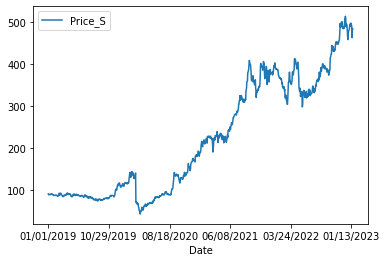

In [ ]:
# Visualize  stock prices
df1.plot.line(y="Price_S", use_index=True)

The stock price has increased over the years.

Next, we want to observe whether there is a relationship between the stock price of this company and the USD (in PKR terms).

Correlation:  0.7726457396683886


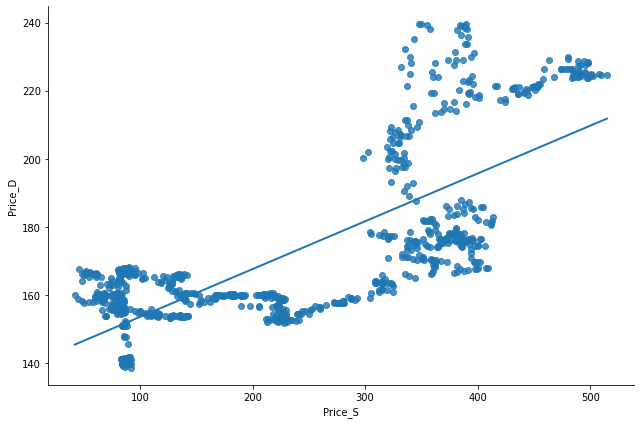

In [4]:
import seaborn as sns
sns.lmplot(x='Price_S',y='Price_D',data=df,height=6,aspect=1.5,line_kws={'linewidth':2},ci= None)


cor1= df['Price_S'].corr(df['Price_D'])
print('Correlation: ',cor1)

With the help of the plot and using the .corr() function, we can confirm that there is a strong positive relationship between the stock price and USD.

In [ ]:
data= df1[['Price_S']]
data

,Price_S
Date,
01/01/2019,89.83
01/03/2019,87.93
01/04/2019,87.93
01/07/2019,88.43
01/08/2019,88.87
...,...
01/13/2023,494.63
01/16/2023,489.50
01/17/2023,463.48


Now, we will prepare the data for prediction. Using information from today, we will forecast if the price will increase or decrease tomorrow.

We will first choose a target for our prediction first. Our goal is to determine whether prices increase or decrease tomorrow. The target will be 1 if the price increased, and 0 if the price decreased.

The data from earlier days will then be "moved forward" by one day so that we can use it to forecast the target price. This prevents us from unintentionally making forecasts based on data from the same day!

In [ ]:
# Ensure we know the actual  price
data = df1[["Price_S"]]
data = data.rename(columns = {'Price_S':'Actual_Price'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = df1.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Price_S"]

In [ ]:
data["Target"].value_counts()

1.0    539
0.0    465
Name: Target, dtype: int64

In [ ]:
nan_count=(data.isna().sum())
print(nan_count)
print(data)

Actual_Price    0
Target          1
dtype: int64
            Actual_Price  Target
Date                            
01/01/2019         89.83     NaN
01/03/2019         87.93     0.0
01/04/2019         87.93     0.0
01/07/2019         88.43     1.0
01/08/2019         88.87     1.0
...                  ...     ...
01/13/2023        494.63     0.0
01/16/2023        489.50     0.0
01/17/2023        463.48     0.0
01/18/2023        479.99     1.0
01/19/2023        485.10     1.0

[1005 rows x 2 columns]


In [ ]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
df1 = df1.copy()
df1 = df1.shift(1)
# Create our training data
predictors = ["Price_S", "Vol._S", "Open_S", "High_S", "Low_S","Price_D"]
data = data.join(df1[predictors]).iloc[1:]

In [ ]:
data

,Actual_Price,Target,Price_S,Vol._S,Open_S,High_S,Low_S,Price_D
Date,,,,,,,,
01/03/2019,87.93,0.0,89.83,14640.0,90.80,90.91,89.30,139.800
01/04/2019,87.93,0.0,87.93,2660.0,86.94,87.93,86.94,139.850
01/07/2019,88.43,1.0,87.93,120.0,90.08,90.08,90.08,139.850
01/08/2019,88.87,1.0,88.43,123180.0,88.43,88.60,88.40,139.850
01/09/2019,89.20,1.0,88.87,38240.0,88.43,90.91,88.41,139.875
...,...,...,...,...,...,...,...,...
01/13/2023,494.63,0.0,498.00,736600.0,499.85,511.00,495.03,228.330
01/16/2023,489.50,0.0,494.63,332390.0,496.00,499.95,486.00,228.600
01/17/2023,463.48,0.0,489.50,250610.0,497.98,497.99,484.50,228.750


Next, we’ll create a machine learning model to see how accurately we can predict the stock price.

In [ ]:
data=data.dropna()
nan_count1= (data.isna().sum())
print(nan_count1)

Actual_Price    0
Target          0
Price_S         0
Vol._S          0
Open_S          0
High_S          0
Low_S           0
Price_D         0
dtype: int64


In [ ]:
data

,Actual_Price,Target,Price_S,Vol._S,Open_S,High_S,Low_S,Price_D
Date,,,,,,,,
01/03/2019,87.93,0.0,89.83,14640.0,90.80,90.91,89.30,139.800
01/04/2019,87.93,0.0,87.93,2660.0,86.94,87.93,86.94,139.850
01/07/2019,88.43,1.0,87.93,120.0,90.08,90.08,90.08,139.850
01/08/2019,88.87,1.0,88.43,123180.0,88.43,88.60,88.40,139.850
01/09/2019,89.20,1.0,88.87,38240.0,88.43,90.91,88.41,139.875
...,...,...,...,...,...,...,...,...
01/13/2023,494.63,0.0,498.00,736600.0,499.85,511.00,495.03,228.330
01/16/2023,489.50,0.0,494.63,332390.0,496.00,499.95,486.00,228.600
01/17/2023,463.48,0.0,489.50,250610.0,497.98,497.99,484.50,228.750


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100,min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

Next, we’ll need to check how accurate the model was. Precision will reveal the percentage of days when the price increased as predicted by the algorithm. High precision is desired because we wish to reduce risk. This indicates that we buy stocks with a high degree of confidence that we will profit from doing so.

In [ ]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6363636363636364

Our model is accurate 63.6% of the time.

In [ ]:
preds

Date
09/01/2022    0.0
09/02/2022    0.0
09/05/2022    0.0
09/06/2022    0.0
09/07/2022    0.0
             ... 
01/13/2023    0.0
01/16/2023    0.0
01/17/2023    0.0
01/18/2023    0.0
01/19/2023    0.0
Length: 100, dtype: float64

Visualize the predictions.

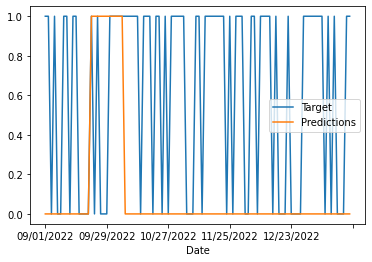

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [ ]:
combined

,Target,Predictions
Date,,
09/01/2022,1.0,0.0
09/02/2022,1.0,0.0
09/05/2022,0.0,0.0
09/06/2022,1.0,0.0
09/07/2022,0.0,0.0
...,...,...
01/13/2023,0.0,0.0
01/16/2023,0.0,0.0
01/17/2023,0.0,0.0


To test on more days, we’ll need to backtest. Backtesting ensures that we only use data from before the day that we’re predicting.

In [ ]:
data

,Actual_Price,Target,Price_S,Vol._S,Open_S,High_S,Low_S,Price_D
Date,,,,,,,,
01/03/2019,87.93,0.0,89.83,14640.0,90.80,90.91,89.30,139.800
01/04/2019,87.93,0.0,87.93,2660.0,86.94,87.93,86.94,139.850
01/07/2019,88.43,1.0,87.93,120.0,90.08,90.08,90.08,139.850
01/08/2019,88.87,1.0,88.43,123180.0,88.43,88.60,88.40,139.850
01/09/2019,89.20,1.0,88.87,38240.0,88.43,90.91,88.41,139.875
...,...,...,...,...,...,...,...,...
01/13/2023,494.63,0.0,498.00,736600.0,499.85,511.00,495.03,228.330
01/16/2023,489.50,0.0,494.63,332390.0,496.00,499.95,486.00,228.600
01/17/2023,463.48,0.0,489.50,250610.0,497.98,497.99,484.50,228.750


In [ ]:

def backtest(data, model, predictors, start=100, step=1):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [ ]:
predictions

,Target,Predictions
Date,,
11/19/2020,0.0,0.0
11/20/2020,0.0,0.0
11/23/2020,0.0,0.0
11/24/2020,1.0,0.0
11/25/2020,1.0,0.0
...,...,...
01/13/2023,0.0,0.0
01/16/2023,0.0,0.0
01/17/2023,0.0,0.0


In [ ]:
predictions["Predictions"].value_counts()

0.0    492
1.0     46
Name: Predictions, dtype: int64

As you can see, the algorithm only predicted that the price would go up 172 times. In the Target, you see that the price actually went up 492 times. So the algorithm predicted the price would go up fewer times than it actually did.

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5

We also have a low precision. This is due to the low amount of predictors to determine when the price would change. Therefore, we will add some more predictors next to help the algorithm make better decisions.

In [ ]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [ ]:
data["weekly_mean"] = weekly_mean["Price_S"] / data["Price_S"]
data["quarterly_mean"] = quarterly_mean["Price_S"] / data["Price_S"]
data["annual_mean"] = annual_mean["Price_S"] / data["Price_S"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open_S"] / data["Price_S"]
data["high_close_ratio"] = data["High_S"] / data["Price_S"]
data["low_close_ratio"] = data["Low_S"] / data["Price_S"]

<ipython-input-360-9a4e2c695529>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["weekly_mean"] = weekly_mean["Price_S"] / data["Price_S"]
<ipython-input-360-9a4e2c695529>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["quarterly_mean"] = quarterly_mean["Price_S"] / data["Price_S"]
<ipython-input-360-9a4e2c695529>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [ ]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5365853658536586

As we can see, our predictions are a bit more accurate than before!

In [ ]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    497
1.0     41
Name: Predictions, dtype: int64

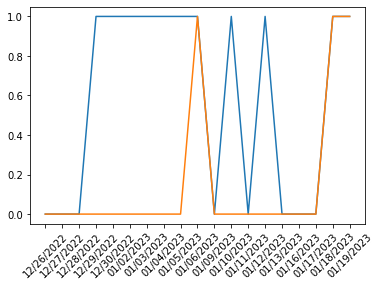

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predictions.iloc[-19:])
plt.xticks(rotation = 45)
plt.show()

We now have a model that we can continue to build on and tweak. The biggest area we can tweak is to continue to improve the accuracy of our predictions and possibly even see how much money we can make if we traded with this algorithm